In [8]:
import numpy as np
import pandas
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pickle
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

## Constants

In [9]:
# file_path = "/nfs/lab/varpred/Final_Results/final_matrices/"
file_path = "./"
t1d_mat = file_path + "T1D_new_04_09_short.bed"
t2d_mat = file_path + "T2D_new_04_09_short.bed"
# topmed_mat = file_path + "topmed_final.bed"

# Automating Experiments

## Data Ingestion

In [3]:
# Raw data from csv
t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')

# Splitting labels and data
t1d_labels_raw = t1d_data_raw["Probability"]
t1d_data_raw = t1d_data_raw.drop(['Locus', 'VarID', 'Probability'], axis=1)

# Filtering out variants with all 0s
print("Originally", len(t1d_data_raw), "variants.", "Filtering out", len(t1d_data_raw) - len(t1d_data_raw[(t1d_data_raw.T != 0).any()]), "variants; left with", len(t1d_data_raw[(t1d_data_raw.T != 0).any()]))

t1d_data = t1d_data_raw[(t1d_data_raw.T != 0).any()]  # Only non-zero variants
t1d_labels = t1d_labels_raw[t1d_labels_raw.index.isin(t1d_data.index)]  # Get matching labels

# Resetting index for splitting
t1d_data = t1d_data.reset_index(drop=True)
t1d_labels = t1d_labels.reset_index(drop=True)

Originally 31341 variants. Filtering out 0 variants; left with 31341


In [4]:
# Removing imbalance columns
t1d_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'imbal' in col])

## Dimensionality Reduction

In [5]:
pca = PCA(n_components=20)

## Label Spreading Model Tests

In [6]:
# Categorical labelling
def label_prob(prob, prob_threshold_high, prob_threshold_low):
    if prob > prob_threshold_high:
        return 1
    elif prob < prob_threshold_low:
        return 0
    else:
        return -1
    
# Split unknown and known data
def sort_data(data, labels):
    known_data_bool = labels != -1
    all_data = data.copy(deep=True)
    all_data.insert(len(all_data.columns), 'label', labels)
    all_data.insert(len(all_data.columns), 'known', known_data_bool)
    all_known_data = all_data[all_data.known == True]
    all_unknown_data = all_data[all_data.known == False]
    known_data = all_known_data.drop(['label', 'known'], axis=1)
    known_labels = all_known_data['label']
    unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
    unknown_labels = all_unknown_data['label']
    
    return all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels


def create_splitter(all_known_data, unknown_data):
    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(all_known_data)

    def custom_splitter(splits):
        for train_index, test_index in splits:
            train_index = np.append(train_index, list(unknown_data.index.values))
            yield train_index, test_index
            
    return splits, custom_splitter


def perform_cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    splits, custom_splitter = create_splitter(all_known_data, unknown_data)
    cv_score = cross_val_score(model, data, y=labels, cv=custom_splitter(splits), verbose=1, n_jobs=1)
    return np.mean(cv_score)

def cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(known_data, known_labels)
    
    total_acc_score = 0
    total_prec_score = 0
    total_rec_score = 0
    total_fp_score = 0
    total_tp_score = 0
    total_tn_score = 0
    total_fn_score = 0
    num = 0
    for train_idx, test_idx in splits:
        train_data = known_data.iloc[train_idx].append(unknown_data)
        test_data = known_data.iloc[test_idx]
        train_labels = known_labels.iloc[train_idx].append(unknown_labels)
        test_labels = known_labels.iloc[test_idx]
        
        rus = RandomUnderSampler(random_state=42)
#         print("Test labels 0/1:", len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))
        test_data, test_labels = rus.fit_resample(test_data, test_labels)
#         print("After balance:", len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))

        model.fit(train_data, train_labels)

        # Predict on test
        pred_labels = model.predict(test_data)

        # Measure accuracy
        acc = accuracy_score(test_labels, pred_labels)
        prec = precision_score(test_labels, pred_labels)
        rec = recall_score(test_labels, pred_labels)
        total_acc_score += acc
        total_prec_score += prec
        total_rec_score += rec
        tn, fp, fn, tp = confusion_matrix(test_labels, pred_labels).ravel()
        total_fp_score += (fp / (fp + tp))
        total_tp_score += (tp / (fp + tp))
        total_fn_score += (fn / (fn + tn))
        total_tn_score += (tn / (fn + tn))
        num += 1

    print("Avg accuracy, precision, recall:", total_acc_score / num, total_prec_score / num, total_rec_score / num)
    print("fp, tp, tn, fn:", total_fp_score / num, total_tp_score / num, total_tn_score / num, total_fn_score / num)
    return total_acc_score / num, total_prec_score / num, total_rec_score / num, total_fp_score / num, total_tp_score / num, total_fn_score / num, total_tn_score / num

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

high_prob_thresholds = [0.01, 0.001, 0.0001]
low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
# high_prob_thresholds = [0.001]
# low_prob_thresholds = [0.000005]
# low_prob_thresholds = [0.00002, 0.000025, 0.00003]
# kernels = ['knn', 'rbf']
kernels = ['rbf']
# gammas = [30, 25, 20, 15, 10, 5]
# gammas = [25, 20, 15]
gammas = [20]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
# n_neighbors = [8, 7, 6]
n_neighbors = [7]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Num Positive Variants",
    "Num Negative Variants",
    "Num Unlabelled Variants",
    "Pos/Neg ratio",
    "Labelled/Unlabelled Ratio",
    "Kernel",
    "alpha",
    "gamma",
    "n_neighbors",
    "Average Accuracy Score",
    "Average Precision Score",
    "Average Recall Score",
    "Avg False Positives",
    "Avg True Positives",
    "Avg False Negatives", 
    "Average True Negatives"
]
res = pandas.DataFrame(columns=res_columns)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        # Label points based on prob thresholds
        print("high: ", prob_thresh_high, "low", prob_thresh_low, end=':')
        print("Positive", len(t1d_labels[t1d_labels > prob_thresh_high]), end='; ')
        print("Negative", len(t1d_labels[t1d_labels < prob_thresh_low]), end='; ')
        print("Unlabelled", len(t1d_labels[(t1d_labels <= prob_thresh_high) & (t1d_labels >= prob_thresh_low)]), end='; ')
        print("")
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        
        # Data stats
        num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
        num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
        num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
        pos_neg_ratio = num_pos / num_neg
        label_ratio = (num_pos + num_neg) / num_unlabelled
        
        alphas += [prob_thresh_high]
        for alpha in alphas:
            for kernel in kernels:
                models = []
                if kernel == 'rbf':
                    for gamma in gammas:
                        model = LabelSpreading(kernel='rbf', alpha=alpha, gamma=gamma)
#                         norm_model = make_pipeline(MinMaxScaler(), pca, model)
                        norm_model = make_pipeline(pca, model)
                        acc, prec, rec, fp, tp, fn, tn = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, gamma, "N/A", acc, prec, rec, fp, tp, fn, tn]
                elif kernel == 'knn':
                    for neighbors in n_neighbors:
                        model = LabelSpreading(kernel="knn", alpha=alpha, n_neighbors=neighbors)
                        norm_model = make_pipeline(Normalizer(), pca, model)
#                         norm_model = make_pipeline(pca, model)
                        acc, prec, rec, fp, tp, fn, tn = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, "N/A", neighbors, acc, prec, rec, fp, tp, fn, tn]

                else:
                    print("Error; invalid kernel")
                    continue

res.to_csv("./Results/rbf_results_PCA_20_components.csv")           

high:  0.01 low 5e-06:Positive 801; Negative 246; Unlabelled 11333; 
Avg accuracy, precision, recall: 0.614516129032258 0.5739905836404197 0.9
fp, tp, tn, fn: 0.42600941635958034 0.5739905836404197 0.7690307787282828 0.2309692212717171
Avg accuracy, precision, recall: 0.614516129032258 0.5739078287261351 0.9032258064516128
fp, tp, tn, fn: 0.426092171273865 0.5739078287261351 0.771015710632079 0.2289842893679211
Avg accuracy, precision, recall: 0.6177419354838709 0.5766726250716105 0.8935483870967742
fp, tp, tn, fn: 0.42332737492838934 0.5766726250716105 0.7661128526645768 0.2338871473354232
high:  0.01 low 6e-06:Positive 801; Negative 705; Unlabelled 10874; 
Avg accuracy, precision, recall: 0.6363636363636364 0.6130087411584422 0.7397727272727274
fp, tp, tn, fn: 0.3869912588415578 0.6130087411584422 0.6730756699866823 0.3269243300133177
Avg accuracy, precision, recall: 0.6323863636363636 0.6102540124695872 0.7329545454545454
fp, tp, tn, fn: 0.38974598753041273 0.6102540124695872 0.6666

Avg accuracy, precision, recall: 0.6115384615384616 0.5877038387749537 0.7472527472527473
fp, tp, tn, fn: 0.4122961612250462 0.5877038387749537 0.6534161290666868 0.3465838709333133
Avg accuracy, precision, recall: 0.6145604395604396 0.5904672123463056 0.7472527472527473
fp, tp, tn, fn: 0.4095327876536944 0.5904672123463056 0.6562564695864933 0.3437435304135067
Avg accuracy, precision, recall: 0.612912087912088 0.5888697620338028 0.7478021978021978
fp, tp, tn, fn: 0.41113023796619724 0.5888697620338028 0.6549059991550485 0.3450940008449514
Avg accuracy, precision, recall: 0.6115384615384615 0.5877899448814167 0.7461538461538462
fp, tp, tn, fn: 0.41221005511858333 0.5877899448814167 0.6530845493520172 0.3469154506479828
Avg accuracy, precision, recall: 0.614010989010989 0.5893998053640505 0.7510989010989011
fp, tp, tn, fn: 0.4106001946359495 0.5893998053640505 0.65757897840324 0.34242102159676
Avg accuracy, precision, recall: 0.6118131868131869 0.5880806329846735 0.7461538461538462
fp, 

Avg accuracy, precision, recall: 0.5630681818181819 0.5348796375940716 0.9681818181818181
fp, tp, tn, fn: 0.4651203624059284 0.5348796375940716 0.8331537477091017 0.1668462522908984
Avg accuracy, precision, recall: 0.5647727272727272 0.5357473783794168 0.9727272727272727
fp, tp, tn, fn: 0.46425262162058323 0.5357473783794168 0.8495241995241998 0.1504758004758005
Avg accuracy, precision, recall: 0.5670454545454545 0.5371328395753101 0.9715909090909092
fp, tp, tn, fn: 0.46286716042468995 0.5371328395753101 0.8536721898790864 0.14632781012091356
Avg accuracy, precision, recall: 0.5676136363636364 0.5374059362698519 0.9727272727272729
fp, tp, tn, fn: 0.4625940637301481 0.5374059362698519 0.8582740912456936 0.1417259087543063
Avg accuracy, precision, recall: 0.5670454545454546 0.537127344384541 0.9715909090909092
fp, tp, tn, fn: 0.46287265561545904 0.537127344384541 0.8513404321026826 0.14865956789731744
Avg accuracy, precision, recall: 0.5681818181818181 0.537752889402833 0.971590909090909

Avg accuracy, precision, recall: 0.601375 0.5799253490949494 0.7365
fp, tp, tn, fn: 0.42007465090505064 0.5799253490949494 0.6389577412668435 0.36104225873315654
Avg accuracy, precision, recall: 0.603375 0.5815568966988593 0.738
fp, tp, tn, fn: 0.4184431033011407 0.5815568966988593 0.6414993912182048 0.35850060878179535
Avg accuracy, precision, recall: 0.603 0.5815768971380965 0.7350000000000001
fp, tp, tn, fn: 0.41842310286190354 0.5815768971380965 0.6400381312024136 0.3599618687975864
Avg accuracy, precision, recall: 0.6030000000000001 0.5817444315449729 0.734
fp, tp, tn, fn: 0.41825556845502704 0.5817444315449729 0.6395806053026128 0.360419394697387
Avg accuracy, precision, recall: 0.6016250000000001 0.5804169170315314 0.7342500000000001
fp, tp, tn, fn: 0.4195830829684687 0.5804169170315314 0.6384539081346261 0.36154609186537395
Avg accuracy, precision, recall: 0.60225 0.5810053518335054 0.734
fp, tp, tn, fn: 0.41899464816649445 0.5810053518335054 0.6389541844569397 0.36104581554306

In [8]:
# t1d_res = pandas.read_csv('./Results/label_spreading_res_normalized_fixed_cv.csv')
# t2d_res = pandas.read_csv('./Results/t2d_normalized_label_spreading.csv')
t1d_res = res

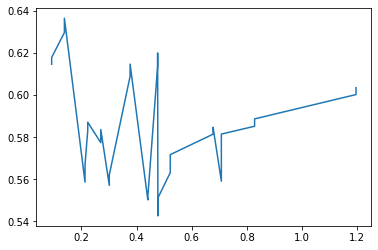

In [9]:
x = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

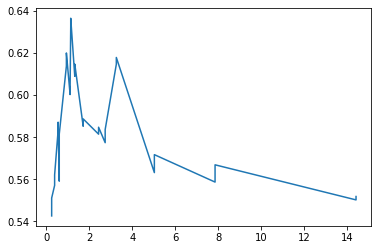

In [10]:
x = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

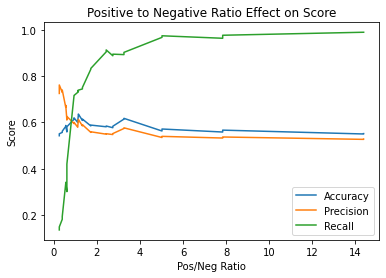

In [11]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

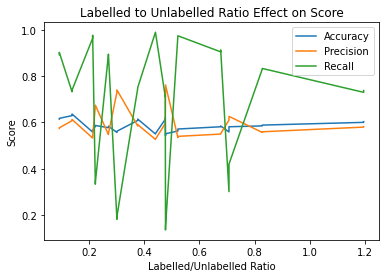

In [12]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

In [6]:
t1d_res = pandas.read_csv('./Results/t1d_ls_precision_accuracy_filtered_tp_fp.csv')

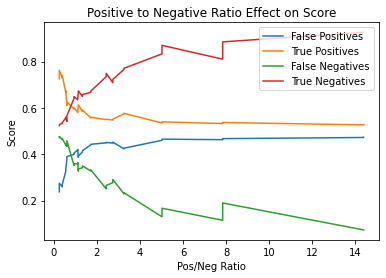

In [13]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
x4 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

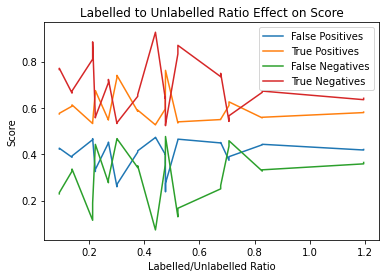

In [14]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
x4 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

high_prob_thresholds = [0.01, 0.001, 0.0001]
low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
# high_prob_thresholds = [0.01]
# low_prob_thresholds = [0.000005, 0.000006, 0.000007]
# low_prob_thresholds = [0.00002, 0.000025, 0.00003]
# kernels = ['knn', 'rbf']
kernels = ['rbf']
# gammas = [30, 25, 20, 15, 10, 5]
# gammas = [25, 20, 15]
gammas = [20]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
# n_neighbors = [8, 7, 6]
n_neighbors = [7]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Num Positive Variants",
    "Num Negative Variants",
    "Num Unlabelled Variants",
    "Pos/Neg ratio",
    "Labelled/Unlabelled Ratio",
    "Kernel",
    "alpha",
    "gamma",
    "n_neighbors",
    "Average Accuracy Score",
    "Average Precision Score",
    "Average Recall Score"
]
res = pandas.DataFrame(columns=res_columns)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        # Label points based on prob thresholds
        print("high: ", prob_thresh_high, "low", prob_thresh_low, end=':')
        print("Positive", len(t1d_labels[t1d_labels > prob_thresh_high]), end='; ')
        print("Negative", len(t1d_labels[t1d_labels < prob_thresh_low]), end='; ')
        print("Unlabelled", len(t1d_labels[(t1d_labels <= prob_thresh_high) & (t1d_labels >= prob_thresh_low)]), end='; ')
        print("")
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        
        # Data stats
        num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
        num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
        num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
        pos_neg_ratio = num_pos / num_neg
        label_ratio = (num_pos + num_neg) / num_unlabelled
        
        alphas += [1 - prob_thresh_high]
        for alpha in alphas:
            for kernel in kernels:
                models = []
                if kernel == 'rbf':
                    for gamma in gammas:
                        model = LabelSpreading(kernel='rbf', alpha=alpha, gamma=gamma)
                        norm_model = make_pipeline(MinMaxScaler(), model)
                        acc, prec, rec = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, gamma, "N/A", acc, prec, rec]
                elif kernel == 'knn':
                    for neighbors in n_neighbors:
                        model = LabelSpreading(kernel="knn", alpha=alpha, n_neighbors=neighbors)
                        norm_model = make_pipeline(Normalizer(), model)
                        acc, prec, rec = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, "N/A", neighbors, acc, prec, rec]

                else:
                    print("Error; invalid kernel")
                    continue

res.to_csv("./Results/t1d_ls_precision_accuracy_filtered.csv")           

In [8]:
t1d_res[t1d_res['Pos/Neg ratio'] > 10]

,Unnamed: 0,Positive Threshold,Negative Threshold,Num Positive Variants,Num Negative Variants,Num Unlabelled Variants,Pos/Neg ratio,Labelled/Unlabelled Ratio,Kernel,alpha,gamma,n_neighbors,Average Accuracy Score,Average Precision Score,Average Recall Score,Avg False Positives,Avg True Positives,Avg False Negatives,Average True Negatives
75,75,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.2000,20,NaN,0.926294,0.977300,0.946022,0.021331,0.917635,0.052376,0.008659
76,76,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.5000,20,NaN,0.926927,0.978200,0.945864,0.020486,0.918479,0.052587,0.008448
77,77,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9900,20,NaN,0.926927,0.978423,0.945668,0.020275,0.918691,0.052798,0.008237
78,78,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9900,20,NaN,0.926927,0.978423,0.945668,0.020275,0.918691,0.052798,0.008237
79,79,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9900,20,NaN,0.926927,0.978423,0.945668,0.020275,0.918691,0.052798,0.008237
80,80,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9900,20,NaN,0.926927,0.978423,0.945668,0.020275,0.918691,0.052798,0.008237
81,81,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9900,20,NaN,0.926927,0.978423,0.945668,0.020275,0.918691,0.052798,0.008237
82,82,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9990,20,NaN,0.927138,0.978648,0.945680,0.020063,0.918902,0.052798,0.008237
83,83,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9990,20,NaN,0.927138,0.978648,0.945680,0.020063,0.918902,0.052798,0.008237
84,84,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9990,20,NaN,0.927138,0.978648,0.945680,0.020063,0.918902,0.052798,0.008237


In [6]:
t1d_data

,Acinar_peaks_bin,Alpha_peaks_bin,Beta_peaks_bin,Delta_peaks_bin,Ductal_peaks_bin,Endo_peaks_bin,Gamma_peaks_bin,Immune_peaks_bin,Stellate_peaks_bin,Acinar_peaks,...,TFA,THA,TP5,TP6,USF,YY1.like,ZEB,ZFX.ZFY,ZNF,ZNF76.like
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12378,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
t1d_res = pandas.read_csv('./Results/balanced_testing_SVC.csv')

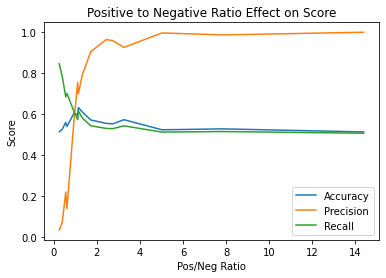

In [12]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

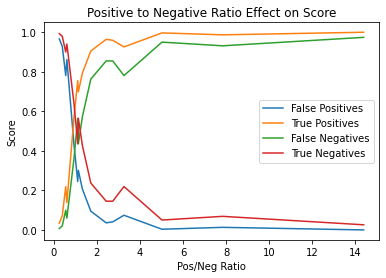

In [13]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
x4 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()